In [1]:
# First, check and install package BiocManager if it has not been already installed
# This package enables installing Bioconductor packages
rm(list=ls())
if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")

In [3]:
# Install the needed libraries and load them
if(!requireNamespace("tweeDEseqCountData", quietly=TRUE)) BiocManager::install("tweeDEseqCountData")
if(!requireNamespace("DESeq2", quietly=TRUE)) BiocManager::install("DESeq2")
library(tweeDEseqCountData)
library(DESeq2)

In [4]:
# Load data from package tweeDEseqCountData
data(pickrell)
data(annotEnsembl63)
data(genderGenes)
ls()

[1] "annotEnsembl63" "msYgenes"       "pickrell.eset"  "XiEgenes"

In [5]:
# chrY genes should be up-regulated in male as compared to female samples
length(msYgenes)
head(msYgenes)

[1] 32

[1] "ENSG00000184895" "ENSG00000129824" "ENSG00000067646" "ENSG00000176679"
[5] "ENSG00000099715" "ENSG00000099721"

In [6]:
# chrX genes that escape inactivation, hence some are up-regulated in female as compared to male samples
length(XiEgenes)
head(XiEgenes)

[1] 63

[1] "ENSG00000173674" "ENSG00000130741" "ENSG00000005889" "ENSG00000131171"
[5] "ENSG00000186310" "ENSG00000157399"

In [7]:
# Ensembl gene annotations
annotEnsembl63[11000:11010,]

,Symbol,Chr,Start,End,EntrezID,Description,Length,GCcontent
,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<int>,<dbl>
ENSG00000183856,IQGAP3,1,156495197,156542396,128239,IQ motif containing GTPase activating protein 3 [Source:HGNC Symbol;Acc:20669],5988,0.5521042
ENSG00000090581,GNPTG,16,1401924,1413352,84572,"N-acetylglucosamine-1-phosphate transferase, gamma subunit [Source:HGNC Symbol;Acc:23026]",2400,0.5529167
ENSG00000148444,COMMD3,10,22604903,22609235,23412,COMM domain containing 3 [Source:HGNC Symbol;Acc:23332],1340,0.5402985
ENSG00000143363,PRUNE,1,150980896,151008189,58497,prune homolog (Drosophila) [Source:HGNC Symbol;Acc:13420],2997,0.4761428
ENSG00000100014,SPECC1L,22,24666786,24838324,135,sperm antigen with calponin homology and coiled-coil domains 1-like [Source:HGNC Symbol;Acc:29022],6673,0.5114641
ENSG00000114993,RTKN,2,74652963,74669549,6242,rhotekin [Source:HGNC Symbol;Acc:10466],2646,0.6001512
ENSG00000135697,BCMO1,16,81272053,81324747,53630,"beta-carotene 15,15'-monooxygenase 1 [Source:HGNC Symbol;Acc:13815]",2670,0.4741573
ENSG00000144554,FANCD2,3,10068098,10143614,2177,"Fanconi anemia, complementation group D2 [Source:HGNC Symbol;Acc:3585]",5219,0.4395478
ENSG00000124225,PMEPA1,20,56223448,56286592,56937,"prostate transmembrane protein, androgen induced 1 [Source:HGNC Symbol;Acc:14107]",4845,0.5376677


In [8]:
# The assay data as a numeric matrix of integer counts (aligned reads from RNA-seq data) is part of the expression set object
# Gender labels are available as part of the phenotypic data of the expression set object
pickrell.eset
PickrellDataSet <- exprs(pickrell.eset)
PickrellDataSet[1:6,1:4]

ExpressionSet (storageMode: lockedEnvironment)
assayData: 52580 features, 69 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: NA18486 NA18498 ... NA19257 (69 total)
  varLabels: num.tech.reps population study gender
  varMetadata: labelDescription
featureData
  featureNames: ENSG00000000003 ENSG00000000005 ... LRG_99 (52580
    total)
  fvarLabels: gene
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

,NA18486,NA18498,NA18499,NA18501
ENSG00000000003,0,0,0,0
ENSG00000000005,0,0,0,0
ENSG00000000419,22,105,40,55
ENSG00000000457,22,100,107,53
ENSG00000000460,5,23,10,18
ENSG00000000938,36,70,41,33


In [9]:
# Check the number of male and female samples
gender <- pickrell.eset$gender
table(gender)

gender
female   male 
    40     29 

In [10]:
# Many genes are unexpressed with zero counts, and could be removed
# Pick genes with <50 zero counts under the 69 samples of the dataset (this should yield 9050 genes)
PickrellDataSet2 <- PickrellDataSet[which(rowSums(PickrellDataSet==0) < 50),]
dim(PickrellDataSet2)

[1] 9050   69

In [11]:
# Build the DESeqDataSet object
coldata <- data.frame(gender, row.names=colnames(PickrellDataSet2))
des <- DESeqDataSetFromMatrix(countData=PickrellDataSet2, colData=coldata, design=~gender)
class(des)
des

[1] "DESeqDataSet"
attr(,"package")
[1] "DESeq2"

class: DESeqDataSet 
dim: 9050 69 
metadata(1): version
assays(1): counts
rownames(9050): ENSG00000000419 ENSG00000000457 ... ENSG00000254221
  ENSG00000254245
rowData names(0):
colnames(69): NA18486 NA18498 ... NA19239 NA19257
colData names(1): gender

In [12]:
# Add meta data columns to the DESeqDataSet object
featureData <- data.frame(annotEnsembl63[rownames(PickrellDataSet2), c("Symbol","Chr")])
mcols(des) <- DataFrame(mcols(des), featureData)
head(mcols(des))

DataFrame with 6 rows and 2 columns
                  Symbol      Chr
                <factor> <factor>
ENSG00000000419 DPM1           20
ENSG00000000457 SCYL3          1 
ENSG00000000460 C1orf112       1 
ENSG00000000938 FGR            1 
ENSG00000001036 FUCA2          6 
ENSG00000001167 NFYA           6 

In [13]:
# Perform Wald test
des <- DESeq(des, test="Wald")
res <- results(des, format="DataFrame")
head(res, n=10)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 84 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



log2 fold change (MLE): gender male vs female 
Wald test p-value: gender male vs female 
DataFrame with 10 rows and 6 columns
                 baseMean log2FoldChange     lfcSE       stat     pvalue
                <numeric>      <numeric> <numeric>  <numeric>  <numeric>
ENSG00000000419  62.71639     0.04003427 0.1135996  0.3524157 0.72452651
ENSG00000000457  70.46817     0.02960941 0.1118618  0.2646964 0.79124336
ENSG00000000460  13.00098     0.16481104 0.1508698  1.0924054 0.27465495
ENSG00000000938  43.56413     0.11407645 0.1953296  0.5840204 0.55920662
ENSG00000001036  37.95191    -0.00594601 0.1079983 -0.0550565 0.95609342
ENSG00000001167 228.48025     0.05202830 0.0968171  0.5373876 0.59099991
ENSG00000001497  11.52425     0.02588545 0.1842754  0.1404715 0.88828743
ENSG00000001561 175.93013     0.30136693 0.1640678  1.8368436 0.06623299
ENSG00000002016   4.68668     0.28107101 0.1920943  1.4631932 0.14341451
ENSG00000002330  66.34023    -0.26473620 0.1021796 -2.5908901 0.0095728

In [14]:
# Construct a data frame for results with meta data columns and sort it by adjusted p-value
df <- as.data.frame(cbind(mcols(des)[, c("Symbol","Chr")], as.data.frame(res)))
df <- df[sort(df$padj, decreasing=FALSE, index.return=TRUE)$ix,]
# Save results in a csv file that can be viewed in Excel
write.csv(df, file="DESeq2_results.csv")

In [15]:
# Identify significant differentially expressed (DE) genes
DE.ind <- which(df$padj < 0.05 & abs(df$log2FoldChange) > 1)
df[DE.ind,]

,Symbol,Chr,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000129824,RPS4Y1,Y,153.6974162,10.389954,0.3400126,30.557554,4.488093e-205,4.061724e-201
ENSG00000099749,CYorf15A,Y,15.3584714,7.581135,0.3462223,21.896729,2.791107e-106,1.262976e-102
ENSG00000198692,EIF1AY,Y,8.1944640,6.798515,0.3684919,18.449562,5.256938e-76,1.585843e-72
ENSG00000154620,TMSB4Y,Y,10.9012209,5.887423,0.3440126,17.113977,1.167478e-65,2.641419e-62
ENSG00000157828,RPS4Y2,Y,5.7103980,6.108990,0.4580313,13.337495,1.400874e-40,2.535581e-37
ENSG00000183878,UTY,Y,0.6086251,3.064890,0.5572857,5.499675,3.804923e-08,4.919222e-05
ENSG00000124216,SNAI1,20,19.0455110,-1.661135,0.3469922,-4.787240,1.690905e-06,1.700299e-03
ENSG00000130222,GADD45G,9,11.8808007,-1.608921,0.3359384,-4.789334,1.673355e-06,1.700299e-03
ENSG00000196407,THEM5,1,8.7160424,-1.145910,0.2587817,-4.428095,9.506890e-06,7.821578e-03


In [16]:
# There are 6 msY genes that are expressed in the dataset. They are the top DE genes in the results Table (as expected)
intersect(rownames(PickrellDataSet2), msYgenes)

[1] "ENSG00000099749" "ENSG00000129824" "ENSG00000154620" "ENSG00000157828"
[5] "ENSG00000183878" "ENSG00000198692"

using ntop=500 top features by variance



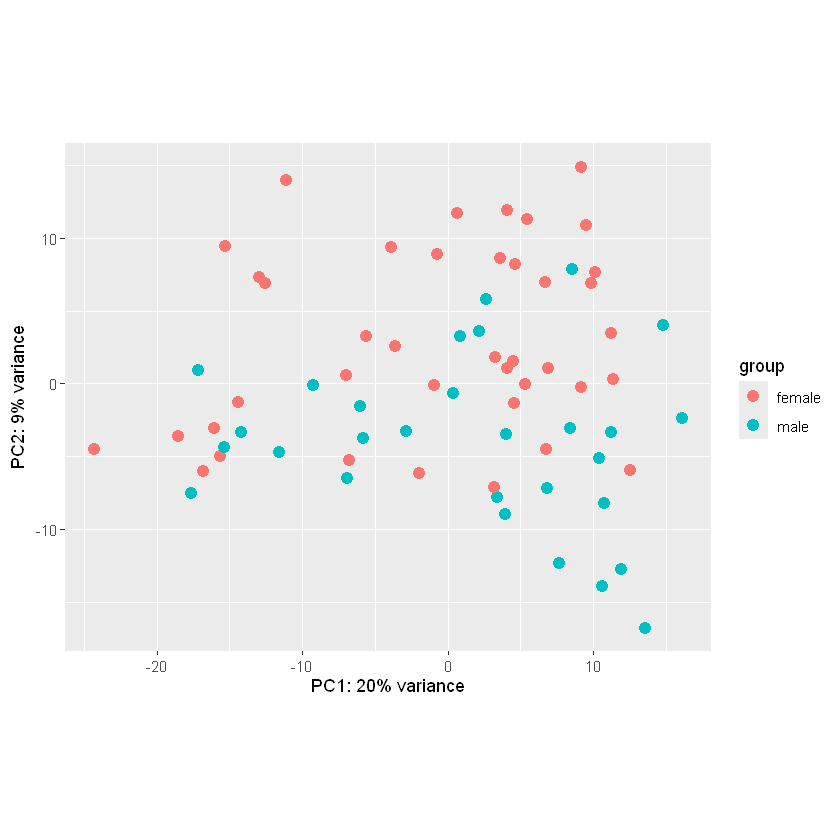

In [17]:
# Apply variance stabilization transform and generate a two-dimensional PCA scatter plot
vsd <- vst(des, blind=FALSE)
plotPCA(vsd, intgroup="gender")

using ntop=500 top features by variance



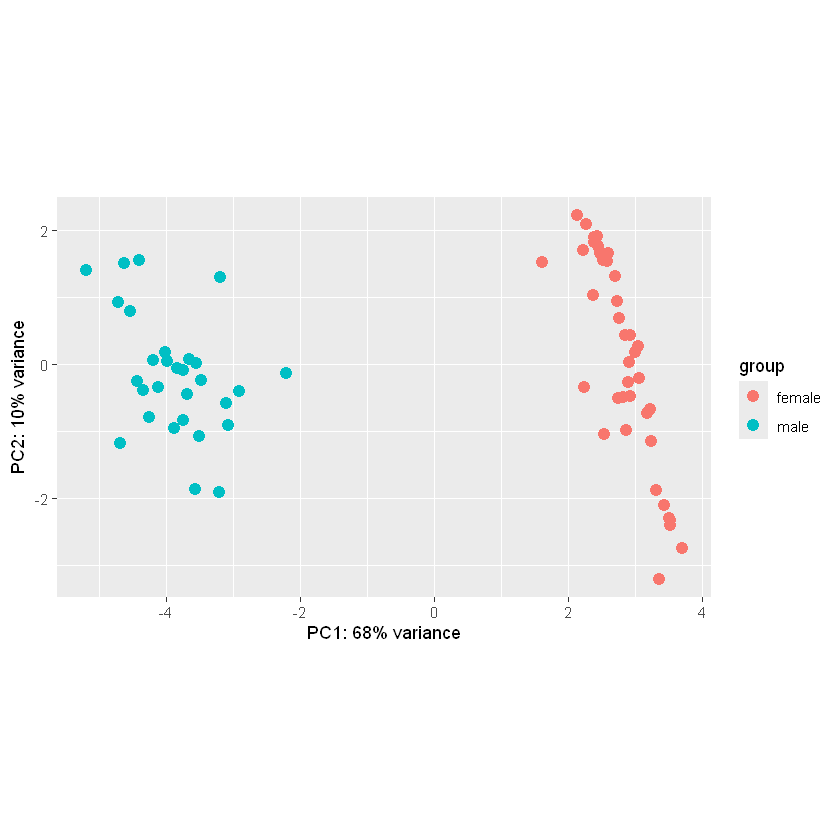

In [18]:
# Generate a second PCA plot using only the significant DE genes
gg <- rownames(df)[DE.ind]
plotPCA(vsd[gg,], intgroup="gender")

**Observation:** The two-dimensional PCA scatter plot shows poor clustering of male and female samples when all the expressed genes were considered. On the contrary, the plot shows two distinct clusters of male and female samples when only 19 significant DE genes are considered.

In [19]:
sessionInfo()

R version 4.4.2 (2024-10-31 ucrt)
Platform: x86_64-w64-mingw32/x64
Running under: Windows 11 x64 (build 22631)

Matrix products: default


locale:
[1] LC_COLLATE=English_United States.utf8 
[2] LC_CTYPE=English_United States.utf8   
[3] LC_MONETARY=English_United States.utf8
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.utf8    

time zone: America/Chicago
tzcode source: internal

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] DESeq2_1.46.0               SummarizedExperiment_1.36.0
 [3] MatrixGenerics_1.18.1       matrixStats_1.5.0          
 [5] GenomicRanges_1.58.0        GenomeInfoDb_1.42.3        
 [7] IRanges_2.40.1              S4Vectors_0.44.0           
 [9] tweeDEseqCountData_1.44.0   Biobase_2.66.0             
[11] BiocGenerics_0.52.0        

loaded via a namespace (and not attached):
 [1] generics_0.1.3          SparseArray_1.6.2       lattice_0.22